### 1. Выберите ряд из первого задания.

In [1]:
import pandas as pd
import numpy as np
import tqdm

from arch import arch_model

from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt

from pmdarima import auto_arima
from statsmodels.tsa.arima_model import ARIMA

from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
airline = pd.read_csv('international-airline-passengers.csv', names=['Month', 'Passengers'], header=0)
airline.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


In [3]:
print(airline['Passengers'].mode()[0])
print(airline['Passengers'].mean())
print(airline['Passengers'].median())
print(np.std(airline['Passengers'], ddof=1))
print(airline['Passengers'].value_counts().head(5))

229
280.2986111111111
265.5
119.96631694294321
Passengers
229    3
306    2
405    2
242    2
196    2
Name: count, dtype: int64


In [4]:
airline['Passengers'] = airline['Passengers'].fillna(airline['Passengers'].mean())

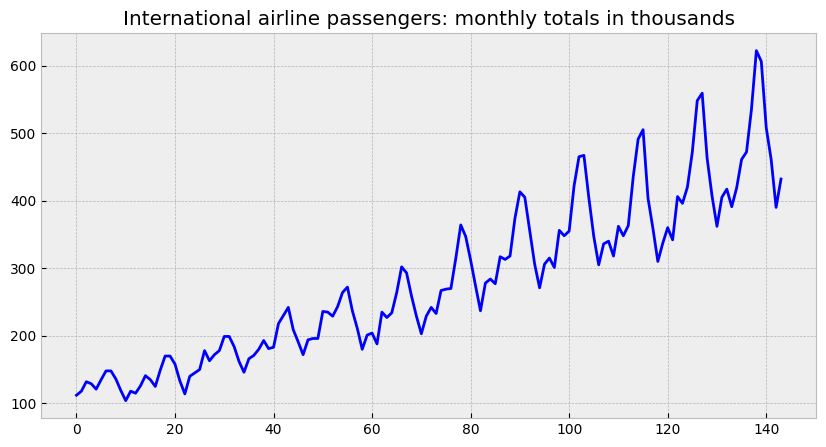

In [5]:
with plt.style.context('bmh'):
    plt.figure(figsize=(10, 5))
    plt.title('International airline passengers: monthly totals in thousands')
    plt.plot(airline['Passengers'], color='blue')

In [6]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [7]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (5, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))
        qq_ax = plt.subplot2grid(layout, (4, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        
        plt.tight_layout()
    return

In [8]:
series = airline['Passengers']
series.shape

(144,)

In [9]:
test_stationarity(series)

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [10]:
series_count = boxcox(series, 0)
series_count = np.diff(series_count, 12)

In [11]:
series_count_fit = auto_arima(series_count, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=1460.883, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=1290.027, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=1458.883, Time=0.01 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=1107.176, Time=0.02 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=1019.504, Time=0.05 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=852.328, Time=0.05 sec
 ARIMA(5,0,0)(0,0,0)[0] intercept   : AIC=739.564, Time=0.08 sec
 ARIMA(5,0,1)(0,0,0)[0] intercept   : AIC=642.895, Time=0.29 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(5,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.32 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.27 sec
 ARIMA(5,0,1)(0,0,0)[0]             : AIC=inf, Time=0.22 sec

Best model:  ARIMA(5,0,1)(0,0,0)[0] intercept
Total fit time: 1.7

In [12]:
series_count_fit.aic

<bound method ARIMA.aic of ARIMA(order=(5, 0, 1), scoring_args={}, suppress_warnings=True)>

### 2. Постройте его модель GARCH.

In [13]:
series = boxcox(series, 0)
series = np.diff(series_count, 1)
series = np.diff(series_count, 12)

In [14]:
series = series.astype(float)

In [15]:
p_ = 4
o_ = 0
q_ = 2

am = arch_model(series, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                            y   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1604.66
Distribution:      Standardized Student's t   AIC:                           3219.31
Method:                  Maximum Likelihood   BIC:                           3233.25
                                              No. Observations:                  120
Date:                      Mon, Jan 29 2024   Df Residuals:                      119
Time:                              15:29:19   Df Model:                            1
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

Results of Dickey-Fuller Test:
Test Statistic                 -20.849166
p-value                          0.000000
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


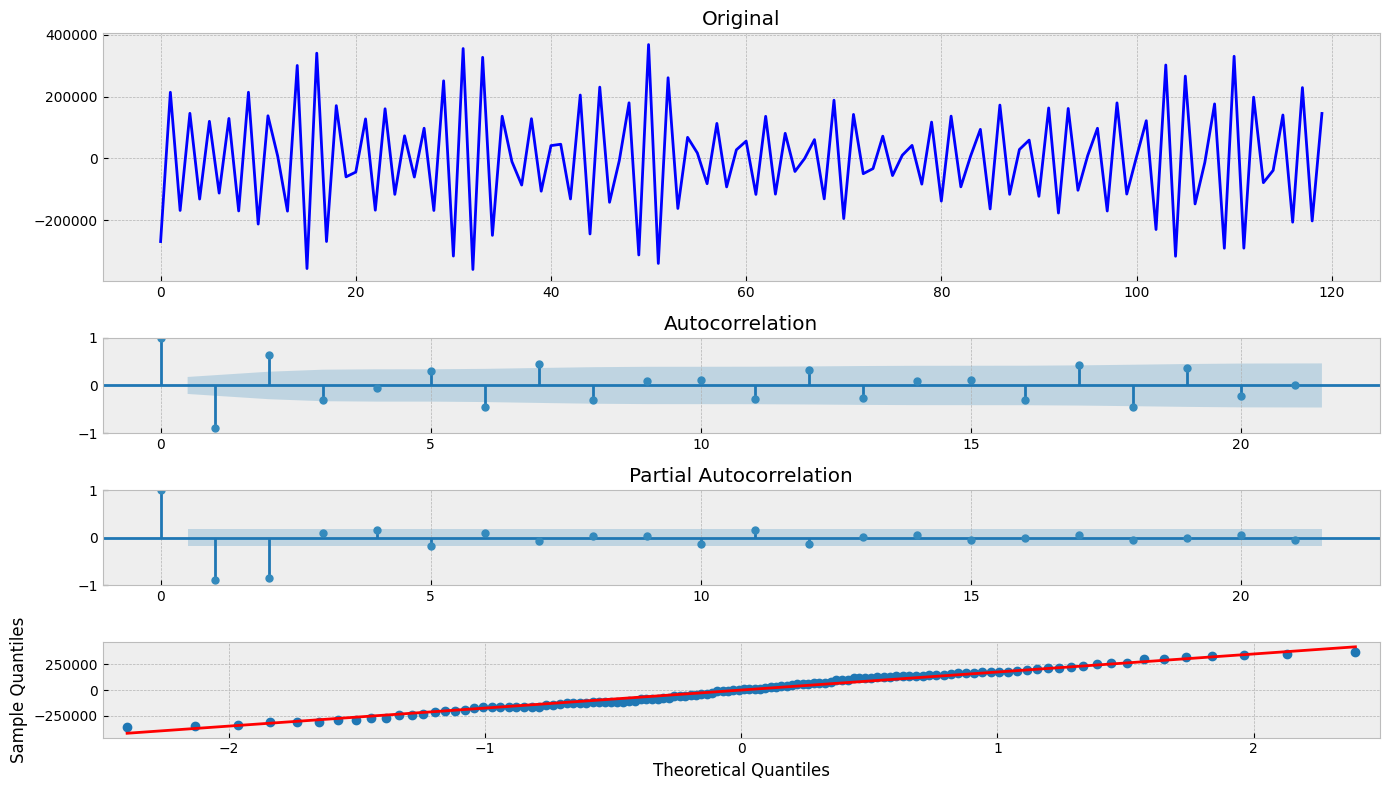

In [16]:
tsplot(res.resid)